In [1]:
import uproot
import matplotlib.pyplot as plt
import scipy as scp
from scipy.optimize import curve_fit 
from scipy.integrate import trapezoid
import numpy as np
import awkward as ak
from lmfit.models import GaussianModel

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Peak estimation

In [2]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))      

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data
#PATH_MARTI="../Dati/Run_chall_ChargeHistos_4_12_2024_10M.dat"


In [3]:
#per il sodio
ch_1=[0,1,4,11,12, 6]
ch_2=[2,15]
ch_3=[3,5,7,13,14]
ch_4=[9,10]

In [4]:
#per il bario
ch_1=[0, ]

In [6]:
channel=5

In [16]:
#PATH="../Dati/Run_Ba_50_1000_ChargeHistos_5_16_2024.dat"
#PATH="../Dati/linearity/Run_2M_50_2000_ChargeHistos_5_10_2024.dat"

#PATH="../Dati/linearity/Run_Ba_40_600_ChargeHistos_5_16_2024.dat"
PATH="../Dati/linearity/Run_Ba_30_1000_ChargeHistos_5_16_2024.dat" #ch 3 5
#PATH="../Dati/linearity/Run_30_600_ChargeHistos_5_16_2024_2.dat" #ch 4
#PATH="../Dati/linearity/Run_Ba_30_2000_ChargeHistos_5_16_2024_2.dat"  #ch 2
#if channel==8:
    #PATH="../Dati/linearity/Run_ch8_ChargeHistos_5_10_2024.dat"
edge_N, bin_N = load_histo(PATH)#, usecols=(0,1,2,3,4,5,6))
#edge_N, bin_N = np.loadtxt(PATH, usecols=(0,1,2,3,4,5,6))


channel_idx = np.arange(0,16, step=1)

# Na peak

## Peak e+e-

In [32]:
edge_N, bin_N = load_histo(PATH)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []



for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [ ]:
edge_N, bin_N = load_histo(PATH)
edge_N = edge_N[0]
bin_N = bin_N[0]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []



for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [40]:
lim_list = [[-575, -460],  #ch0
            [-110, -55],      #ch1      #èsbaglaito
            [-1850, -1550],  #ch2
            [-1200, -1000],  #ch3
            [-825, -700],  #ch4
            [-1400, -1160],  #ch5
            [-920, -775],  #ch6
            [-1350, -1110],  #ch7
            [-1060, -880],  #ch8
            [-550, -435],  #ch9
            [-490, -400],  #ch10
            [-900, -700],  #ch11
            [-800, -620],      #ch12
            [-1240, -1010],      #ch13
            [-1250, -1000],  #ch14
            [-1700, -1500]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

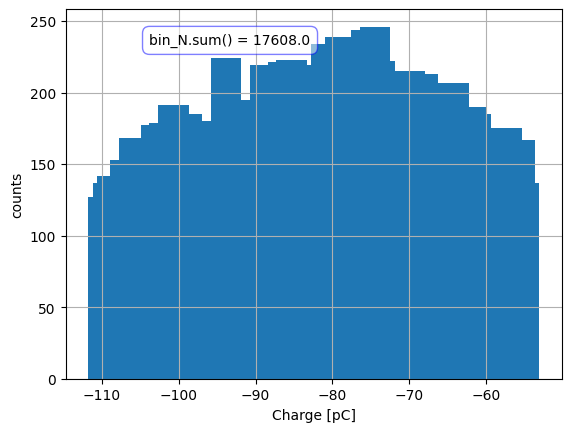

In [41]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

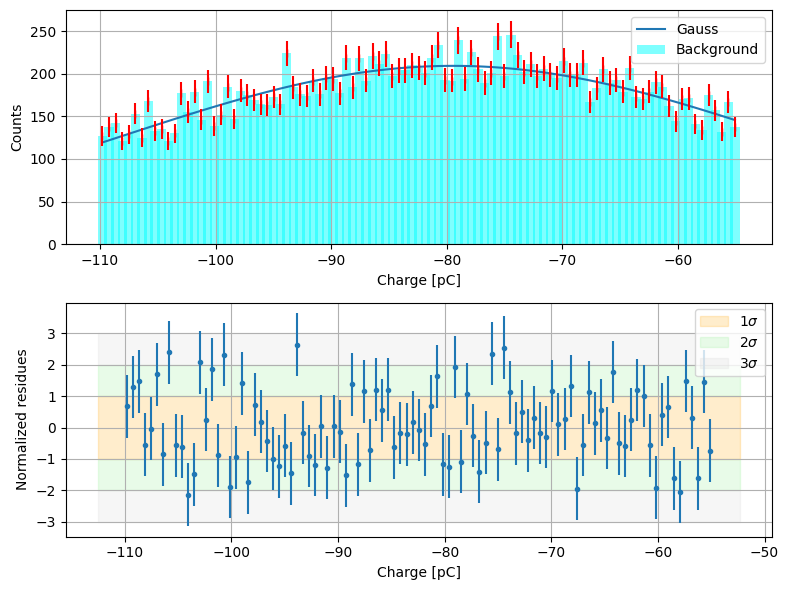

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 97
    # variables        = 3
    chi-square         = 135.713642
    reduced chi-square = 1.44376215
    Akaike info crit   = 38.5761032
    Bayesian info crit = 46.3002361
    R-squared          = 0.71416978
[[Variables]]
    g3_amplitude:  15022.0024 +/- 405.333619 (2.70%) (init = 7374.375)
    g3_center:    -79.4549337 +/- 0.52663937 (0.66%) (init = -78.9288)
    g3_sigma:      28.6398551 +/- 0.98991516 (3.46%) (init = 19.665)
    g3_fwhm:       67.4417035 +/- 2.33107201 (3.46%) == '2.3548200*g3_sigma'
    g3_height:     209.250787 +/- 2.71926373 (1.30%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.9403
    C(g3_amplitude, g3_center) = +0.3522
    C(g3_center, g3_sigma)     = +0.3255


In [42]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

## f peak

In [244]:
channel=15

In [245]:
if channel in ch_1:
    PATH_SAM="../Dati/Run_1M_50_3000_ChargeHistos_5_10_2024.dat"
elif channel in ch_2:
    PATH_SAM="../Dati/Run_2M_50_5000_ChargeHistos_5_10_2024.dat"
elif channel in ch_3:
    PATH_SAM="../Dati/Run_2M_50_4000_ChargeHistos_5_10_2024.dat"
elif channel in ch_4:
    PATH_SAM="../Dati/Run_2M_50_2000_ChargeHistos_5_10_2024.dat"
if channel==8:
    PATH_SAM="../Dati/Run_ch8_ChargeHistos_5_10_2024.dat"


#PATH_SAM="../Dati/Run_2M_50_2000_ChargeHistos_5_10_2024.dat"
edge_N, bin_N = load_histo(PATH_SAM)



channel_idx = np.arange(0,16, step=1)

In [246]:
edge_N, bin_N = load_histo(PATH_SAM)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []

for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [256]:
lim_list = [[-1345, -1127],  #ch0
            [-1250, -1040],      #ch1
            [-4400, -3750],  #ch2
            [-2950, -2550],  #ch3
            [-2000, -1700],  #ch4
            [-3390, -2800],  #ch5
            [-2300, -1900],  #ch6
            [-3200, -2700],  #ch7
            [-2450, -2155],  #ch8
            [-1350, -1100],  #ch9
            [-1150, -1000],  #ch10
            [-2100, -1750],  #ch11
            [-1900, -1600],      #ch12
            [-3000, -2500],      #ch13
            [-3000, -3500],  #ch14
            [-4200, -3500]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

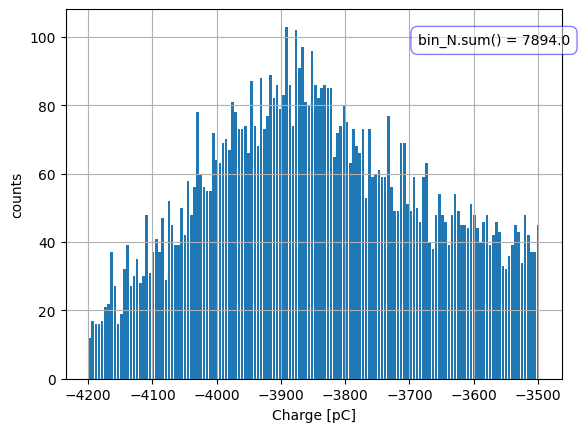

In [257]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

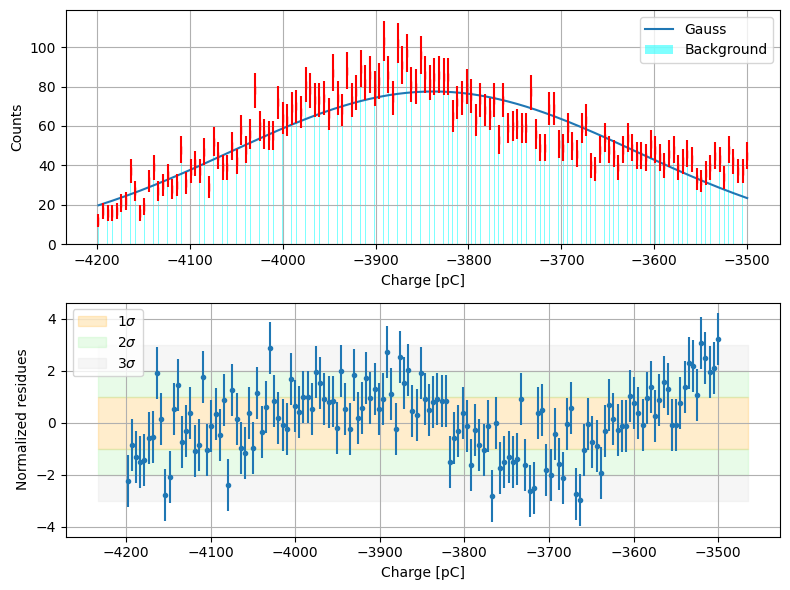

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 142
    # variables        = 3
    chi-square         = 258.582067
    reduced chi-square = 1.86030264
    Akaike info crit   = 91.1128206
    Bayesian info crit = 99.9803018
    R-squared          = 0.76683852
[[Variables]]
    g3_amplitude:  42348.5545 +/- 776.936964 (1.83%) (init = 50675.62)
    g3_center:    -3837.62880 +/- 4.46804932 (0.12%) (init = -3864.407)
    g3_sigma:      218.068390 +/- 5.29597928 (2.43%) (init = 185.625)
    g3_fwhm:       513.511806 +/- 12.4710779 (2.43%) == '2.3548200*g3_sigma'
    g3_height:     77.4739967 +/- 1.65901533 (2.14%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.5250
    C(g3_center, g3_sigma)     = +0.2080
    C(g3_amplitude, g3_center) = +0.1314


In [258]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

## conclusions

In [38]:
peak_e=np.abs(np.array([-506.734, -461.730, -1673.738, -1085.422, -758.996, -1258.207, -854.866, -1216.707, -948.590, -506.800,
       -437.591, -776.004, -705.231, -1121.940, -1111.193, -1593.873]))
sigma_e=np.array([0.715, 0.789, 0.664, 0.844, 0.620, 1.360, 0.91, 1.116, 0.613, 1.236, 
         0.469, 0.955, 1.196, 0.961, 1.043, 1.558])
peak_f=np.abs(np.array([-1216.816, -1142.936, -4043.482, -2679.389, -1825.805, -3077.995, -2076.421, -2938.099, -2288.095, -1217.833,
       -1056.445, -1899.582, -1726.943, -2728.146, -2700.407, -3837.629] ))
sigma_f=np.array([1.615, 1.780, 2.493, 3.325, 1.683, 3.790, 2.369, 3.218, 1.281, 1.511,
        0.967, 2.157, 2.608, 2.609, 2.604, 4.468])

In [42]:
peak_e[14]

1111.193

# Ba peaks

## peak 1

In [27]:
edge_N, bin_N = load_histo(PATH)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []

for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [30]:
lim_list = [[-450, -80],  #ch0
            [-110, -50],      #ch1      #rispetto a prima è cambiato un sacco :(
            [-150, -90],  #ch2
            [-108, -55],  #ch3  #108 55
            [-70, -45],  #ch4
            [-110, -40],  #ch5
            [-80, -50],  #ch6
            [-1350, -1110],  #ch7
            [-1060, -880],  #ch8
            [-130, -70],  #ch9
            [-490, -400],  #ch10
            [-900, -700],  #ch11
            [-800, -620],      #ch12
            [-1240, -1010],      #ch13
            [-1250, -1000],  #ch14
            [-1700, -1500]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

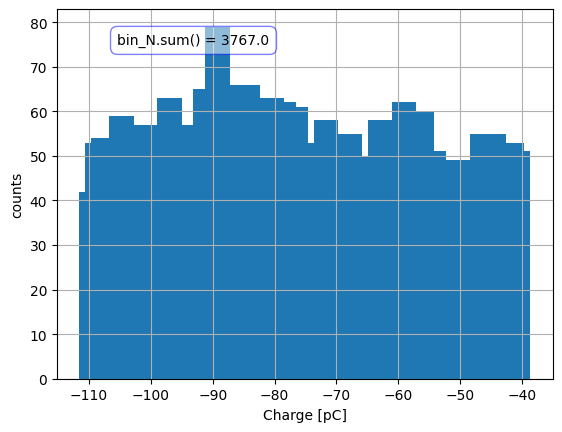

In [31]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()

plt.xlabel("Charge [pC]")
plt.ylabel("counts")


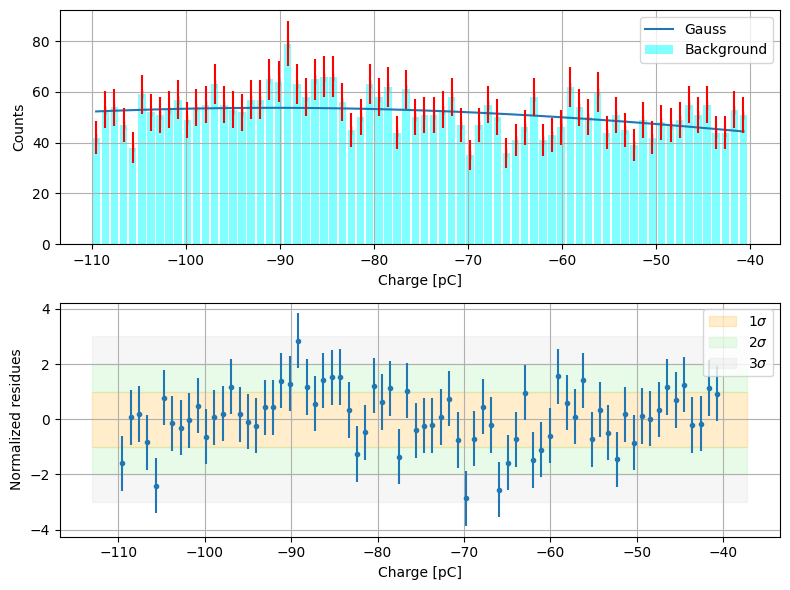

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 72
    # variables        = 3
    chi-square         = 79.1662164
    reduced chi-square = 1.14733647
    Akaike info crit   = 12.8316140
    Bayesian info crit = 19.6616124
    R-squared          = 0.11929747
[[Variables]]
    g3_amplitude:  10931.4682 +/- 3429.40965 (31.37%) (init = 3201)
    g3_center:    -90.7645392 +/- 11.1197741 (12.25%) (init = -81.57167)
    g3_sigma:      81.1552928 +/- 26.1099629 (32.17%) (init = 24.25)
    g3_fwhm:       191.106107 +/- 61.4842630 (32.17%) == '2.3548200*g3_sigma'
    g3_height:     53.7367917 +/- 1.26966396 (2.36%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.9976
    C(g3_amplitude, g3_center) = -0.8709
    C(g3_center, g3_sigma)     = -0.8511


In [32]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

## peak 2

In [33]:
edge_N, bin_N = load_histo(PATH)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []

for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [38]:
lim_list = [[-575, -460],  #ch0
            [-400, -300],      #ch1      #rispetto a prima è cambiato un sacco :(
            [-360, -270],  #ch2
            [-220, -140],  #ch3
            [-160, -100],  #ch4
            [-300, -110],  #ch5
            [-180, -100],  #ch6
            [-1350, -1110],  #ch7
            [-1060, -880],  #ch8
            [-225, -130],  #ch9
            [-490, -400],  #ch10
            [-900, -700],  #ch11
            [-800, -620],      #ch12
            [-1240, -1010],      #ch13
            [-1250, -1000],  #ch14
            [-1700, -1500]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

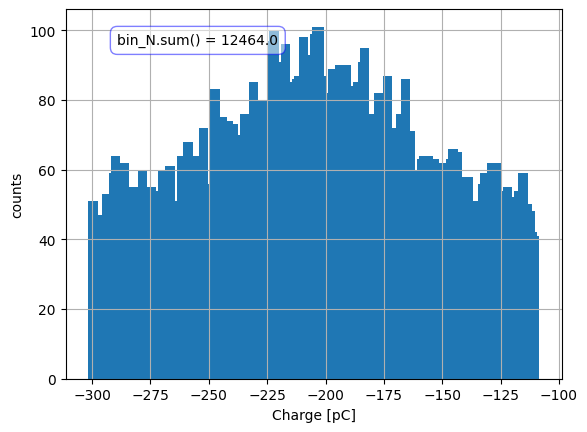

In [39]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

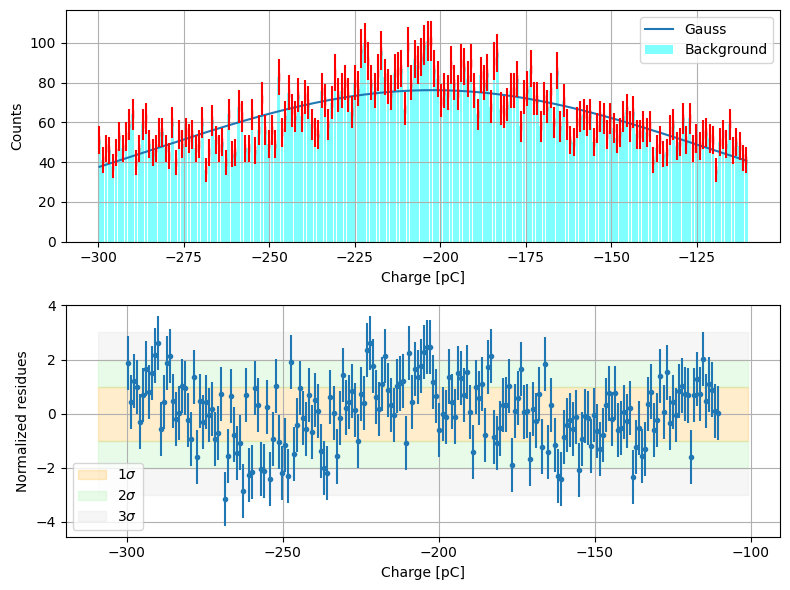

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 196
    # variables        = 3
    chi-square         = 292.797802
    reduced chi-square = 1.51708706
    Akaike info crit   = 84.6680529
    Bayesian info crit = 94.5023968
    R-squared          = 0.60164339
[[Variables]]
    g3_amplitude:  15670.3626 +/- 353.426991 (2.26%) (init = 8606.325)
    g3_center:    -202.278411 +/- 1.50377067 (0.74%) (init = -205.2134)
    g3_sigma:      81.9962311 +/- 2.56049097 (3.12%) (init = 44.135)
    g3_fwhm:       193.086365 +/- 6.02949534 (3.12%) == '2.3548200*g3_sigma'
    g3_height:     76.2421690 +/- 1.22971414 (1.61%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma) = +0.8687


In [40]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

## peak 3

In [62]:
edge_N, bin_N = load_histo(PATH)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []

for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [63]:
lim_list = [[-575, -460],  #ch0
            [-530, -425],      #ch1      #rispetto a prima è cambiato un sacco :(
            [-1120, -900],  #ch2
            [-700, -500],  #ch3
            [-477, -350],  #ch4
            [-800, -600],  #ch5
            [-400, -200],  #ch6
            [-1350, -1110],  #ch7
            [-1060, -880],  #ch8
            [-550, -435],  #ch9
            [-490, -400],  #ch10
            [-900, -700],  #ch11
            [-800, -620],      #ch12
            [-1240, -1010],      #ch13
            [-1250, -1000],  #ch14
            [-1700, -1500]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

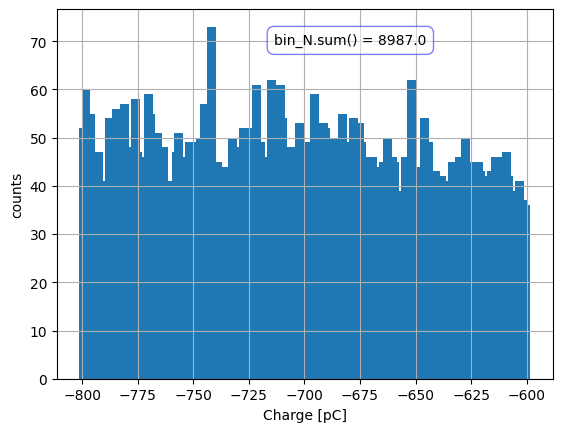

In [64]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

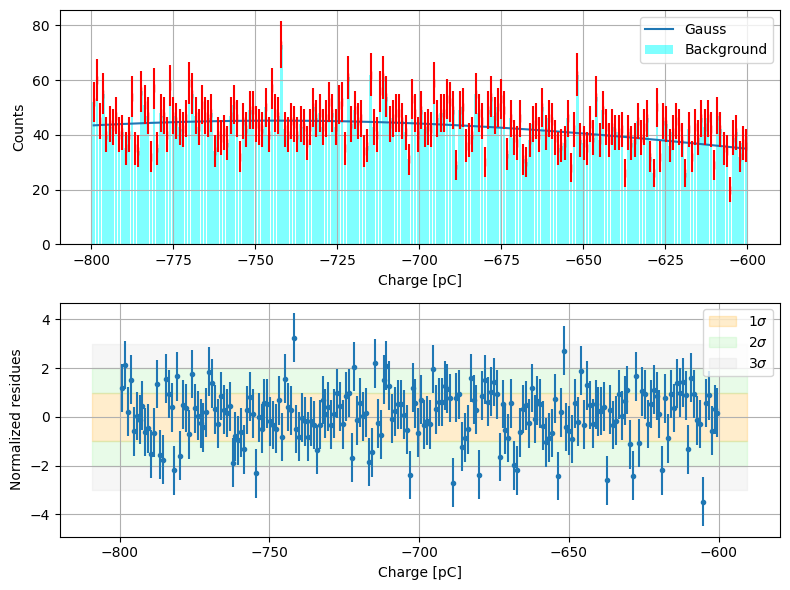

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 206
    # variables        = 3
    chi-square         = 249.201997
    reduced chi-square = 1.22759604
    Akaike info crit   = 45.2198518
    Bayesian info crit = 55.2034803
    R-squared          = 0.11669557
[[Variables]]
    g3_amplitude:  22610.0252 +/- 3539.25970 (15.65%) (init = 15114.54)
    g3_center:    -743.502880 +/- 16.0118870 (2.15%) (init = -724.0857)
    g3_sigma:      199.654871 +/- 32.2740510 (16.16%) (init = 95.06)
    g3_fwhm:       470.151283 +/- 75.9995809 (16.16%) == '2.3548200*g3_sigma'
    g3_height:     45.1784392 +/- 0.70666903 (1.56%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.9957
    C(g3_amplitude, g3_center) = -0.8780
    C(g3_center, g3_sigma)     = -0.8537


In [65]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

## Peak 4


In [66]:
edge_N, bin_N = load_histo(PATH)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []

for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [70]:
lim_list = [[-420, -340],  #ch0
            [-530, -425],      #ch1      #rispetto a prima è cambiato un sacco :(
            [-1395, -1160],  #ch2
            [-900, -700],  #ch3
            [-600, -477],  #ch4
            [-1000, -800],  #ch5
            [-675, -543],  #ch6
            [-1350, -1110],  #ch7
            [-1060, -880],  #ch8
            [-550, -435],  #ch9
            [-490, -400],  #ch10
            [-900, -700],  #ch11
            [-800, -620],      #ch12
            [-1240, -1010],      #ch13
            [-1250, -1000],  #ch14
            [-1700, -1500]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

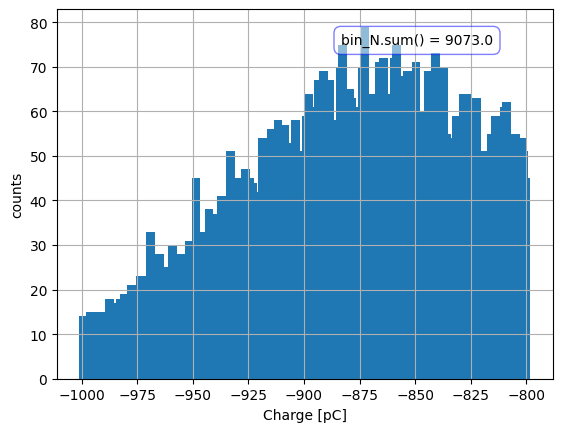

In [71]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

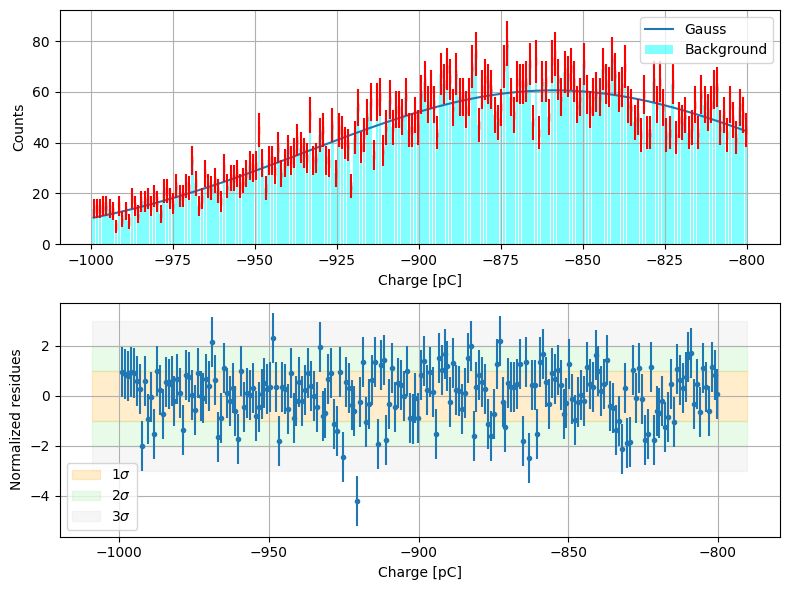

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 206
    # variables        = 3
    chi-square         = 220.433871
    reduced chi-square = 1.08588114
    Akaike info crit   = 19.9506446
    Bayesian info crit = 29.9342731
    R-squared          = 0.84882173
[[Variables]]
    g3_amplitude:  11367.2166 +/- 241.269753 (2.12%) (init = 16028.28)
    g3_center:    -858.807669 +/- 1.94449147 (0.23%) (init = -862.8258)
    g3_sigma:      74.7841619 +/- 1.81412472 (2.43%) (init = 74.205)
    g3_fwhm:       176.103240 +/- 4.27193719 (2.43%) == '2.3548200*g3_sigma'
    g3_height:     60.6393574 +/- 0.84500913 (1.39%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.8204
    C(g3_amplitude, g3_center) = +0.7782
    C(g3_center, g3_sigma)     = +0.7650


In [72]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

## conclusions

In [ ]:
#      [0,1,2,     3,    4,5,6,7,8,9,10,11,12,13,14,15]

ch_3=[-74.440,  -178.235,  -752.729]
err_ch_3=[0.680, 0.340, 0.531]
ch_4=[-49.941, -125.157, -251.742, -515.91]
err_ch_4=[2.493, 0.239, 1.586, 0.319] 
ch_6=[-55.019, -138.954, -275.364, -588.489]
err_ch_6=[2.409, 0.372, 1.748, 0.44]
ch_9=[]
err_ch_9=[]

#peak_4=[]
#err_4=[]


# Linearity

In [91]:
new_sigma_e= np.sqrt(sigma_e**2 + (0.01*peak_e)**2)
new_sigma_f= np.sqrt(sigma_e**2 + (0.01*peak_e)**2)
energy=np.array((511, 1274))

In [94]:
#faccio intercalibrazione rispetto al canale 2
lista=np.arange(0,16,step=1)
channel_ref=2
coeff_cal=peak_e/peak_e[channel_ref]
err_e=new_sigma_e/coeff_cal

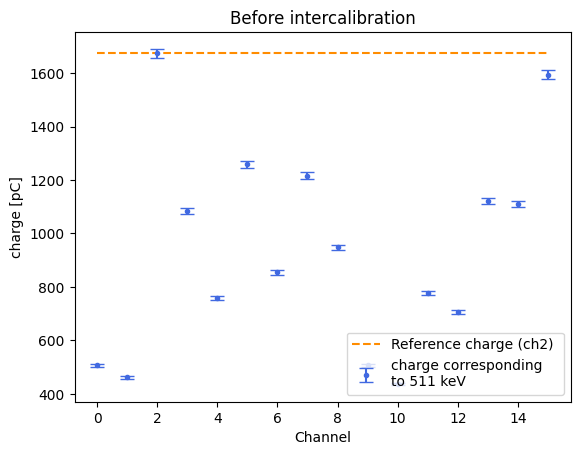

In [95]:
ref=peak_e[channel_ref]

plt.errorbar(lista, peak_e, yerr=new_sigma_e, ls='', capsize=5, marker='.', color='royalblue', label='charge corresponding\nto 511 keV')
plt.title("Before intercalibration")
plt.plot(lista, 0*np.array(lista) + ref, color='darkorange', ls='--', label='Reference charge (ch2) '.format(channel_ref))
plt.xlabel('Channel')
plt.ylabel("charge [pC]")
plt.legend(loc='lower right')

[-1.44051793  5.86447497  0.          5.25250137 -1.02522667  3.03184712
  1.30303538 -0.10390771 -0.37303776 -1.24878598 -0.160084    3.18229741
  3.24594322  1.57358107  1.42851281 -0.80625922]
[0.00420568 0.00409842 0.0041426  0.00406323 0.00417089 0.00411156
 0.00414028 0.00415852 0.00415441 0.00428346 0.00416583 0.00411595
 0.004142   0.00412752 0.004133   0.00417307]


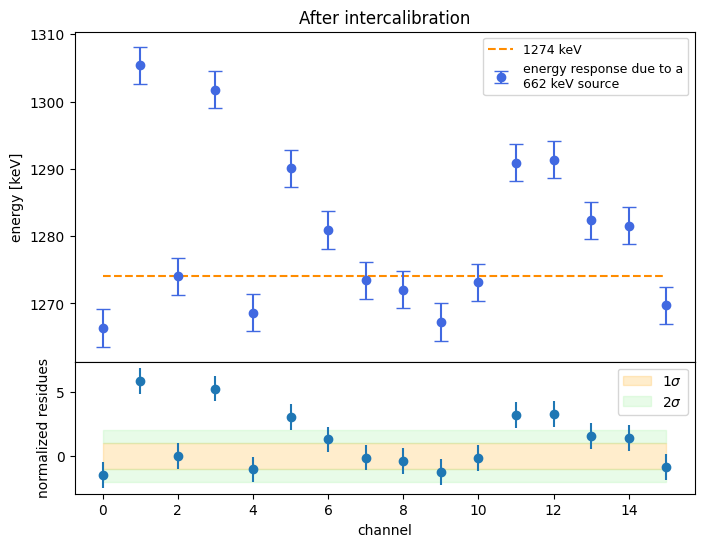

In [96]:
test_peak_centers=peak_f/coeff_cal

test_peak_errors=new_sigma_f/coeff_cal
ref=peak_f[channel_ref]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [5, 2]})

print( (test_peak_centers-ref)/test_peak_errors  )
ax1.plot(lista, 0*np.array(lista) + 1274, color='darkorange', ls='--', label='1274 keV '.format(channel_ref))
ax1.errorbar(lista, test_peak_centers*1274/ref, yerr=test_peak_errors*662/np.abs(ref), ls='', capsize=5, marker='o', color='royalblue', label='energy response due to a\n662 keV source')
ax1.legend(fontsize=9)
ax1.set_title("After intercalibration")
ax1.set_ylabel("energy [keV]")

xlim = ax1.get_xlim()
ax2.errorbar(lista,(np.array(test_peak_centers)-ref)/np.array(test_peak_errors), yerr=1, ls=' ', marker='o')
ax2.fill_between([0,15], [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between([0,15], [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between([0,15], [2, 2], [1, 1], color = "lightgreen", alpha = 0.2)
ax2.set_xlabel("channel")
ax2.set_ylabel("normalized residues")
ax2.legend()
plt.subplots_adjust(hspace=0)

print(test_peak_errors/test_peak_centers)

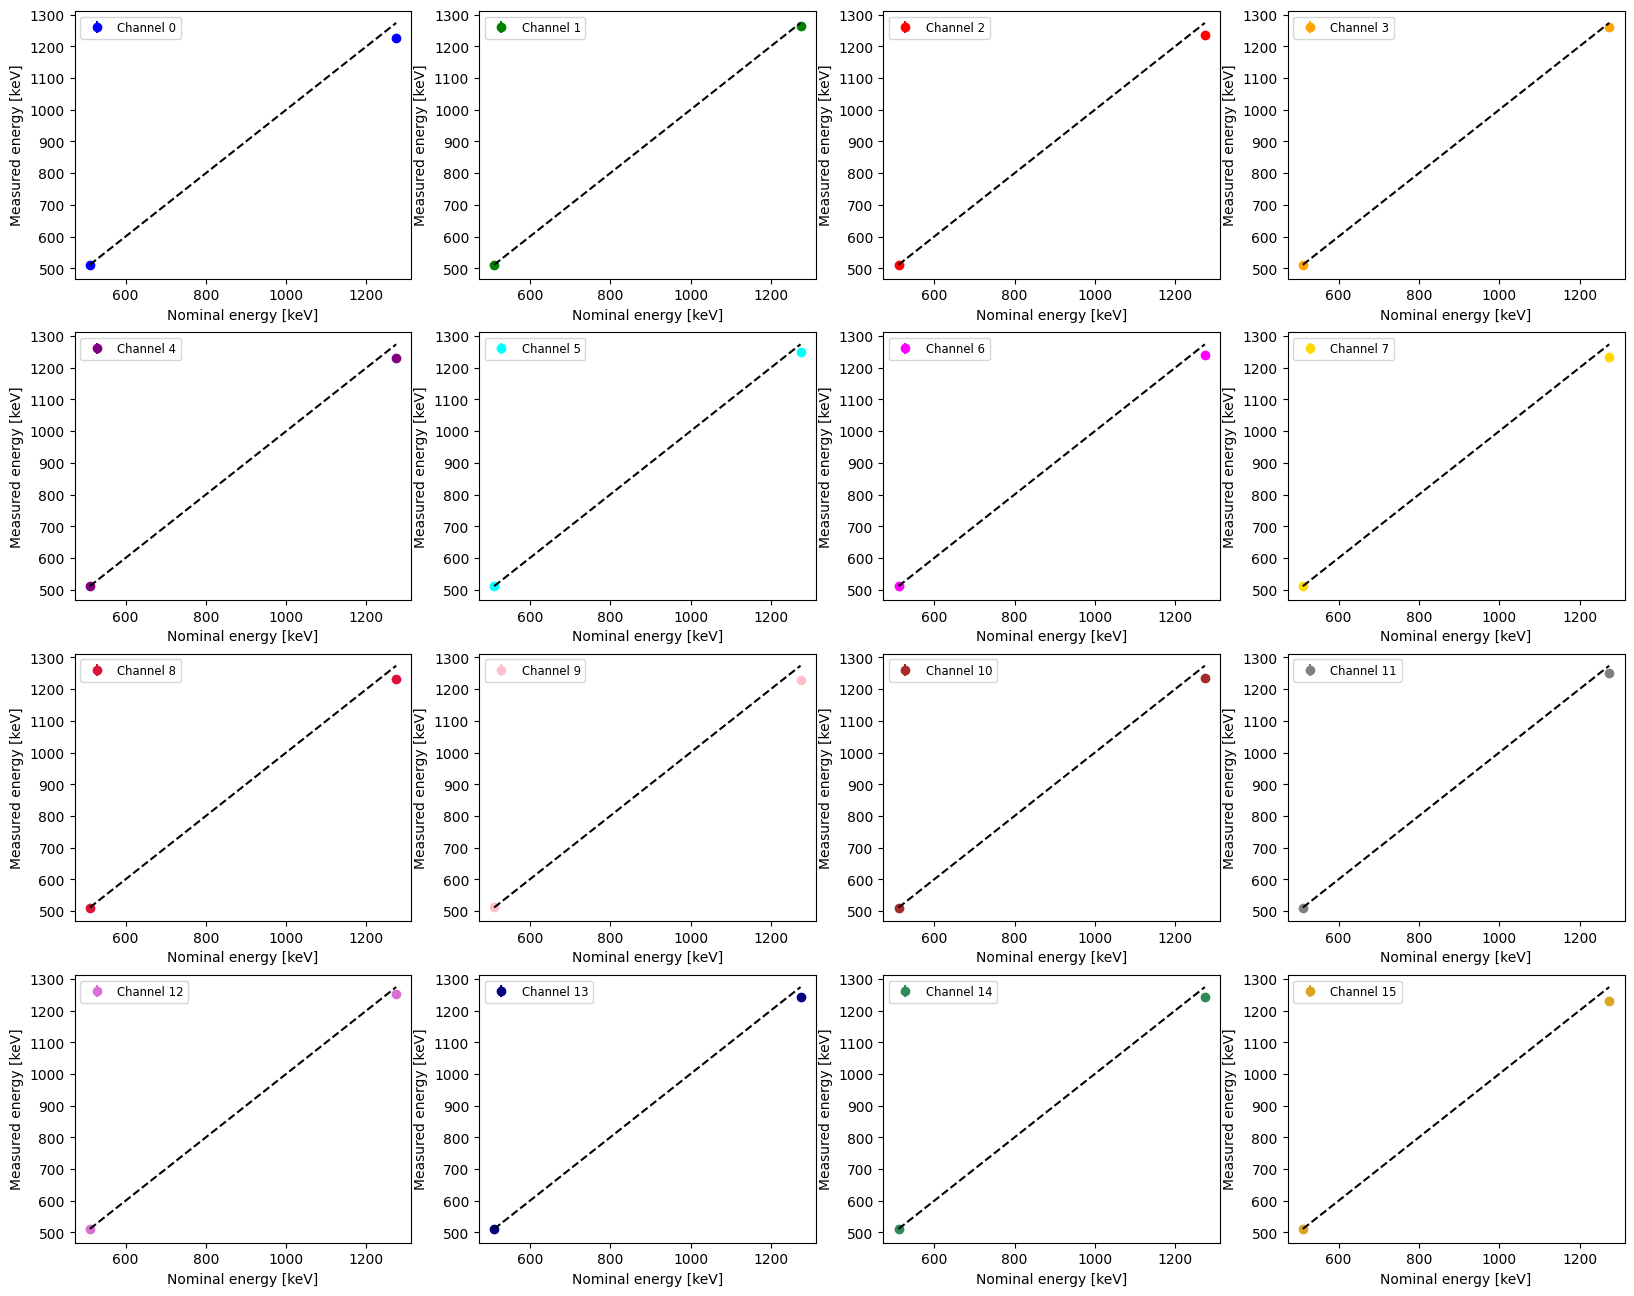

In [98]:

ch=np.arange(0,16,step=1)
colors = ['blue', 'green', 'red', 'orange', 'purple', 'cyan', 'magenta', 'gold', 'crimson', 'pink', 'brown', 'gray', 'orchid', 'navy', 
          'seagreen', 'goldenrod']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))#, sharex=True)
ref_g=peak_e[channel_ref]
energia=511/ref_g
energy_g=peak_e/coeff_cal*energia
sigma_g=new_sigma_e/coeff_cal*energia
ref_f=peak_f[channel_ref]
energy_f=test_peak_centers*energia
sigma_f=test_peak_errors*energia
# Iterate over each element in channels
for j, color in enumerate(colors):
    # Calculate subplot row and column
    row = j // 4
    col = j % 4
    
    # Plot error bars on the corresponding subplot with different color
    axes[row, col].errorbar(energy, np.array([energy_g[j], energy_f[j]]), yerr=np.array([sigma_g[j], sigma_f[j]]), 
                            ls='', marker='o', color=color, label='Channel {}'.format(j))

   

    axes[row, col].errorbar(energy, energy, ls='--', color='black')
    
    axes[row, col].set_xlabel("Nominal energy [keV]")
    axes[row, col].set_ylabel("Measured energy [keV]")
    axes[row, col].legend(fontsize='small')  # Add legend for each subplot

# Linearity for each channel

In [41]:
peak_e=np.abs(np.array([-506.734, -461.730, -1673.738, -1085.422, -758.996, -1258.207, -854.866, -1216.707, -948.590, -506.800,
       -437.591, -776.004, -705.231, -1121.940, -1111.193, -1593.873]))
sigma_e=np.array([0.715, 0.789, 0.664, 0.844, 0.620, 1.360, 0.91, 1.116, 0.613, 1.236, 
         0.469, 0.955, 1.196, 0.961, 1.043, 1.558])
peak_f=np.abs(np.array([-1216.816, -1142.936, -4043.482, -2679.389, -1825.805, -3077.995, -2076.421, -2938.099, -2288.095, -1217.833,
       -1056.445, -1899.582, -1726.943, -2728.146, -2700.407, -3837.629] ))
sigma_f=np.array([1.615, 1.780, 2.493, 3.325, 1.683, 3.790, 2.369, 3.218, 1.281, 1.511,
        0.967, 2.157, 2.608, 2.609, 2.604, 4.468])

In [42]:
def retta(x, a, b):
    return(a*x + b)

In [43]:
channel_ref=2

ref_g=peak_e[channel_ref]
energia=511/ref_g

coeff_cal=peak_e/peak_e[channel_ref]

### ch 0

In [63]:
ch_0=np.abs([-506.734, -1216.816, -359.830]/coeff_cal[0]*energia)
en_ch_0=[511, 1274, 356]
sigma_ch_0=[0.715, 1.615, 0.792]/coeff_cal[0]*energia  #0.792 è da sistemare, solo errore del fit
ch=0

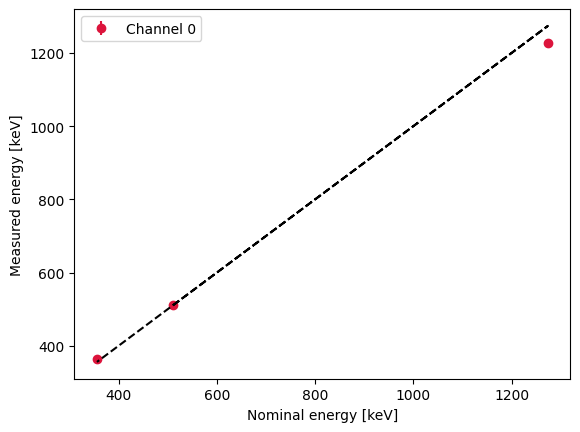

In [64]:
plt.errorbar(en_ch_0, ch_0, yerr=sigma_ch_0, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
plt.errorbar(en_ch_0, en_ch_0, ls='--', color='black')
plt.xlabel("Nominal energy [keV]")
plt.ylabel("Measured energy [keV]")
plt.legend()  # Add legend for each subplot

### ch 1

In [149]:
ch=1
ch_1=np.abs([-461.730, -1142.936, -78.992, -315.134])/coeff_cal[ch]*energia
en_ch_1=[511, 1274, 81,  302.5 ]
sigma_ch_1=np.sqrt(np.array([0.789, 1.780, 0.5, 1.049])**2+(ch_1*0.01)**2)/coeff_cal[ch]*energia


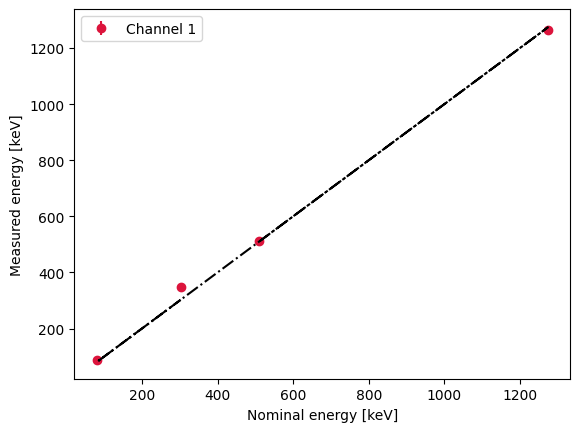

In [150]:
plt.errorbar(en_ch_1, ch_1, yerr=sigma_ch_1, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
plt.errorbar(en_ch_1, en_ch_1, ls='-.', color='black')
plt.xlabel("Nominal energy [keV]")
plt.ylabel("Measured energy [keV]")
plt.legend()  # Add legend for each subplot

### ch2

In [40]:
ch=2 
ch_2=np.abs([-1673.738, -4043.482, -122.249, -309.287, -1064.259,  -1245.953])/coeff_cal[ch]*energia
en_ch_2=np.array([511, 1274, 30.85, 81, (276.4*0.088+302.85*0.666)/(0.088+0.666), (356.02*0.738+383.9*0.317)/(0.317+0.738) ])
sigma_ch_2=np.sqrt(np.array([ 0.664, 2.493, 0.141, 0.226, 2.641, 0.493])**2 + (ch_2*0.01)**2)/coeff_cal[ch]*energia
par, cov= curve_fit(retta, en_ch_2, ch_2, sigma=sigma_ch_2)
print(par, np.sqrt(cov[0][0]), np.sqrt(cov[1][1]))

[1.00845264 7.21958999] 0.02547061797872522 2.0180588844008223


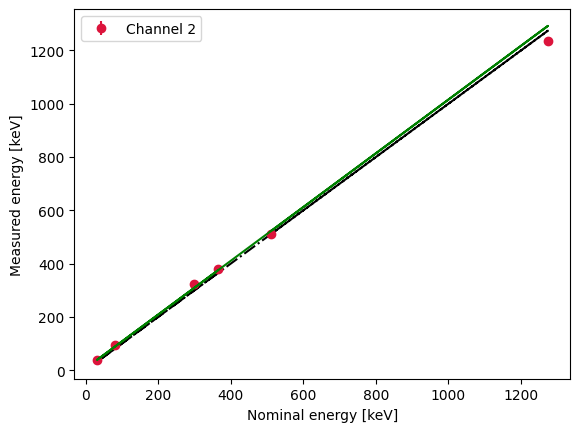

In [41]:
plt.errorbar(en_ch_2, ch_2, yerr=sigma_ch_2, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
plt.errorbar(en_ch_2, retta(en_ch_2, par[0], par[1]), color='green')
plt.plot(en_ch_2, en_ch_2, ls='-.', color='black')
plt.xlabel("Nominal energy [keV]")
plt.ylabel("Measured energy [keV]")
plt.legend()  # Add legend for each subplot

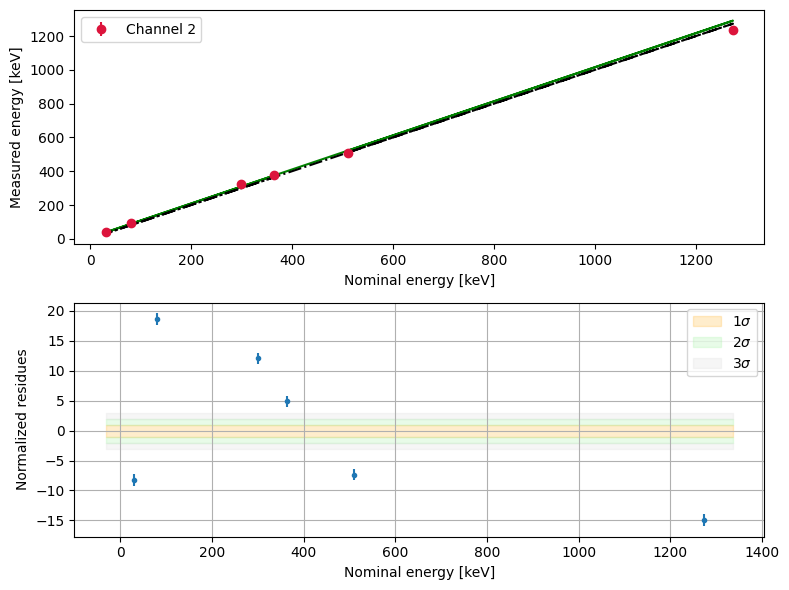

[-11.53888777 -57.49437961  -1.00716529   5.52250671  15.40684984
   5.69832801]


In [39]:


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.errorbar(en_ch_2, ch_2, yerr=sigma_ch_2, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
ax1.plot(en_ch_2, retta(en_ch_2,par[0], par[1]), color='green')
ax1.plot(en_ch_2, en_ch_2, ls='-.', color='black')
ax1.set_xlabel("Nominal energy [keV]")
ax1.set_ylabel("Measured energy [keV]")
ax1.legend()  # Add legend for each subplot

residue= ch_2 - retta(en_ch_2, par[0], par[1])
norm_res = residue / sigma_ch_2

ax2.errorbar(en_ch_2, norm_res, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Nominal energy [keV]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(residue)

In [42]:
#kolmogorov smirnov
print(' ')
print('Test del K-S per il set 2')
t2=[]
valori=residue
N=len(valori)
media=np.mean(valori)
sigma=np.std(valori)
for j in range(0,N):
  t2.append((valori[j] - media)/sigma)
t2=sorted(t2)
print(t2)

 
Test del K-S per il set 2
[-2.103272578868079, -0.18009311607673537, 0.26064620779062025, 0.5339047580594779, 0.5412626582115474, 0.9475520708831686]


In [47]:
diff=[]
cumulata=[0.167, 0.167*2, 0.167*3, 0.167*4, 0.167*5, 1]
#devi metterci i valori che ottieni facendo 1/N e sommandoli
#in t2 devi mettere i valori di t ottenuti con distcalc
#devi mettere 1-alpha di distcalc
t=[1-0.98228, 1-0.57146, 1-0.39718, 1-0.2967, 1-0.29416, 1-0.17168]
for i in range(0,N):
  diff.append(cumulata[i]-t[i])
print(f'differenza={diff}')
#cerca il valore nella tabella
print(min(diff))
print(max(diff))
#la significatività è superiore al 20%

differenza=[0.14928000000000005, -0.09454000000000001, -0.10182000000000002, -0.0353, 0.12916000000000005, 0.17168000000000005]
-0.10182000000000002
0.17168000000000005


### ch 3

In [117]:
ch=3
ch_3=np.abs([peak_e[ch], peak_f[ch], -75.484, -178.424, -753.299, -703.840])/coeff_cal[ch]*energia
en_ch_3=np.array([511, 1274, 30.85, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738), (276.4*0.088+302.85*0.666)/(0.088+0.666)])
sigma_ch_3=np.sqrt(np.array([sigma_e[ch], sigma_f[ch], 0.708, 0.534, 0.969, 21.606])**2+(ch_3*0.01)**2)/coeff_cal[ch]*energia
par3, cov3= curve_fit(retta, en_ch_3, ch_3, sigma=sigma_ch_3)
print(par3, np.sqrt(cov3[0][0]), np.sqrt(cov3[1][1]))

[0.97884197 5.02595707] 0.008962747033662524 1.0509041646774242


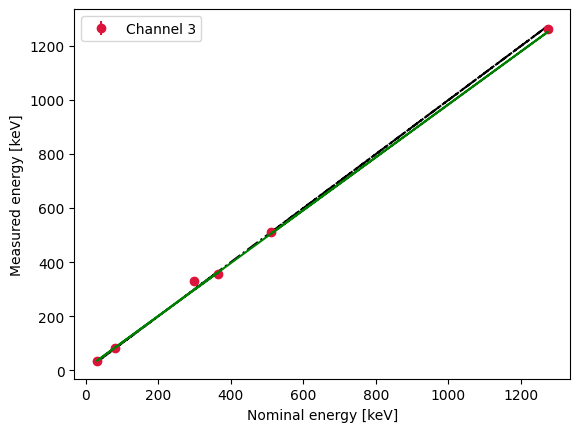

In [118]:
plt.errorbar(en_ch_3, ch_3, yerr=sigma_ch_3, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
plt.errorbar(en_ch_3, retta(en_ch_3, par3[0], par3[1]), color='green')
plt.plot(en_ch_3, en_ch_3, ls='-.', color='black')
plt.xlabel("Nominal energy [keV]")
plt.ylabel("Measured energy [keV]")
plt.legend()  # Add legend for each subplot

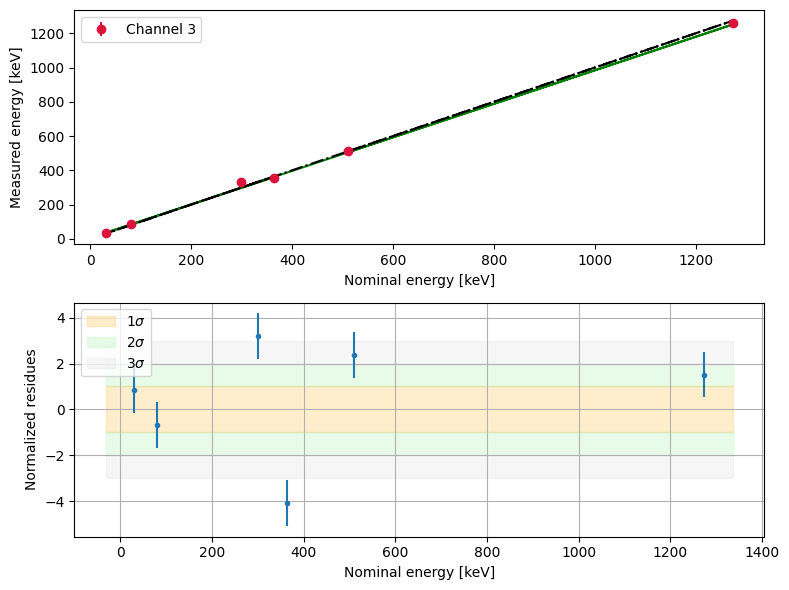

[ 5.78579801  9.34454966  0.31347564 -0.31287866 -7.07164723 32.91049854]


In [119]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.errorbar(en_ch_3, ch_3, yerr=sigma_ch_3, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
ax1.plot(en_ch_3, retta(en_ch_3,par3[0], par3[1]), color='green')
ax1.plot(en_ch_3, en_ch_3, ls='-.', color='black')
ax1.set_xlabel("Nominal energy [keV]")
ax1.set_ylabel("Measured energy [keV]")
ax1.legend()  # Add legend for each subplot

residue= ch_3 - retta(en_ch_3, par3[0], par3[1])
norm_res = residue / sigma_ch_3

ax2.errorbar(en_ch_3, norm_res, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Nominal energy [keV]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(residue)

In [ ]:
#kolmogorov smirnov
print(' ')
print('Test del K-S per il set 2')
t2=[]
valori=residue
N=len(valori)
media=np.mean(valori)
sigma=np.std(valori)
for j in range(0,N):
  t2.append((valori[j] - media)/sigma)
t2=sorted(t2)
print(t2)

In [ ]:
diff=[]
cumulata=[0.167, 0.167*2, 0.167*3, 0.167*4, 0.167*5, 1]
#devi metterci i valori che ottieni facendo 1/N e sommandoli
#in t2 devi mettere i valori di t ottenuti con distcalc
#devi mettere 1-alpha di distcalc
t=[1-0.98228, 1-0.57146, 1-0.39718, 1-0.2967, 1-0.29416, 1-0.17168]
for i in range(0,N):
  diff.append(cumulata[i]-t[i])
print(f'differenza={diff}')
#cerca il valore nella tabella
print(min(diff))
print(max(diff))
#la significatività è superiore al 20%

### ch 4

In [181]:
ch=4
ch_4=np.abs([peak_e[ch], peak_f[ch], -53.037, -125.63, -516.241, -462.6])/coeff_cal[ch]*energia  #l'ultimo è con molta fantasia, è una mini gobba
en_ch_4=np.abs([511, 1274, 30.85, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738), (276.4*0.088+302.85*0.666)/(0.088+0.666)])
#en_ch_3=np.array([511, 1274, 30.85, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738), (276.4*0.088+302.85*0.666)/(0.088+0.666)])
sigma_ch_4=np.sqrt(np.array([sigma_e[ch], sigma_f[ch], 0.638, 0.307, 0.510, 6.676])**2+(ch_4*0.01)**2)/coeff_cal[ch]*energia
par4, cov4= curve_fit(retta, en_ch_4, ch_4, sigma=sigma_ch_4)
print(par4, np.sqrt(cov4[0][0]), np.sqrt(cov4[1][1]))

[0.96458281 6.11652967] 0.013022292865970864 1.4927430253022926


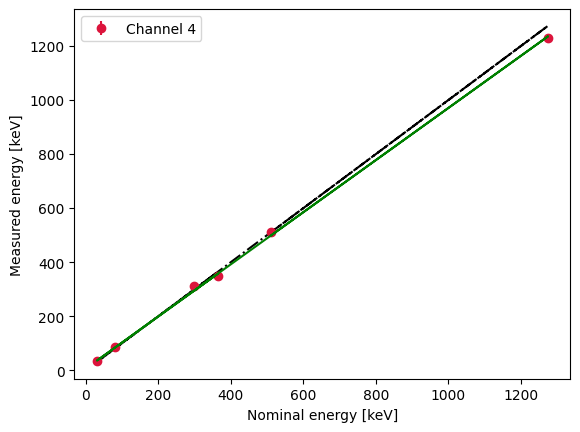

In [182]:
plt.errorbar(en_ch_4, ch_4, yerr=sigma_ch_4, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
plt.errorbar(en_ch_4, retta(en_ch_4, par4[0], par4[1]), color='green')
plt.plot(en_ch_4, en_ch_4, ls='-.', color='black')
plt.xlabel("Nominal energy [keV]")
plt.ylabel("Measured energy [keV]")
plt.legend()  # Add legend for each subplot

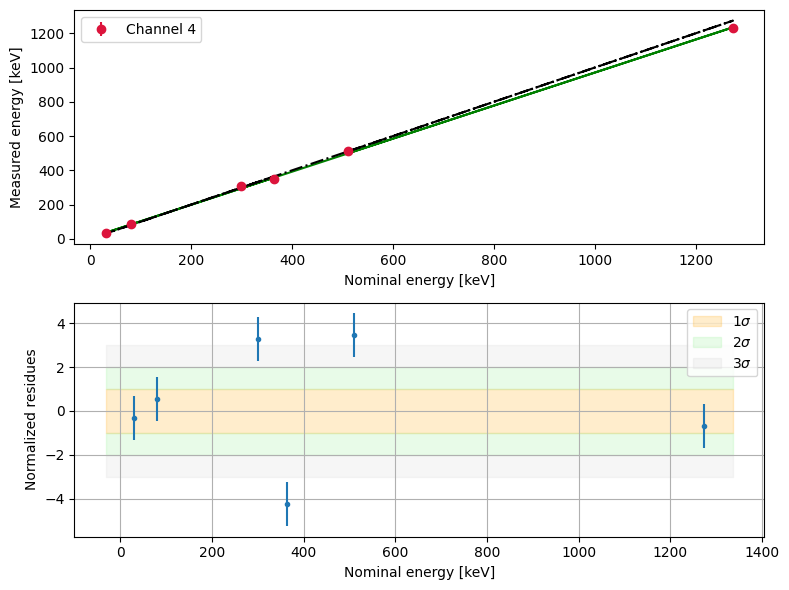

[ 11.9816552   -5.75751521  -0.16633378   0.33364403 -10.04452159
  16.18630867]


In [183]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.errorbar(en_ch_4, ch_4, yerr=sigma_ch_4, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
ax1.plot(en_ch_4, retta(en_ch_4,par4[0], par4[1]), color='green')
ax1.plot(en_ch_4, en_ch_4, ls='-.', color='black')
ax1.set_xlabel("Nominal energy [keV]")
ax1.set_ylabel("Measured energy [keV]")
ax1.legend()  # Add legend for each subplot

residue= ch_4- retta(en_ch_4, par4[0], par4[1])
norm_res = residue / sigma_ch_4

ax2.errorbar(en_ch_4, norm_res, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Nominal energy [keV]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(residue)

In [ ]:
#kolmogorov smirnov
print(' ')
print('Test del K-S per il set 2')
t2=[]
valori=residue
N=len(valori)
media=np.mean(valori)
sigma=np.std(valori)
for j in range(0,N):
  t2.append((valori[j] - media)/sigma)
t2=sorted(t2)
print(t2)

In [ ]:
diff=[]
cumulata=[0.167, 0.167*2, 0.167*3, 0.167*4, 0.167*5, 1]
#devi metterci i valori che ottieni facendo 1/N e sommandoli
#in t2 devi mettere i valori di t ottenuti con distcalc
#devi mettere 1-alpha di distcalc
t=[1-0.98228, 1-0.57146, 1-0.39718, 1-0.2967, 1-0.29416, 1-0.17168]
for i in range(0,N):
  diff.append(cumulata[i]-t[i])
print(f'differenza={diff}')
#cerca il valore nella tabella
print(min(diff))
print(max(diff))
#la significatività è superiore al 20%

### ch 5

In [84]:
ch=5
ch_5=np.abs([peak_e[ch], peak_f[ch], -202.278, -858.808,  -743.503])/coeff_cal[ch]*energia
en_ch_5=np.array([511, 1274, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738), (276.4*0.088+302.85*0.666)/(0.088+0.666)])
#en_ch_3=np.array([511, 1274, 30.85, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738), (276.4*0.088+302.85*0.666)/(0.088+0.666)])
sigma_ch_5=[sigma_e[ch], sigma_f[ch], 1.504, 1.944, 16.012]/coeff_cal[ch]*energia
par5, cov5= curve_fit(retta, en_ch_5, ch_5, sigma=sigma_ch_5)
print(par5, np.sqrt(cov5[0][0]), np.sqrt(cov5[1][1]))

[0.98477187 1.7502978 ] 0.013783789738727169 6.487031811526151


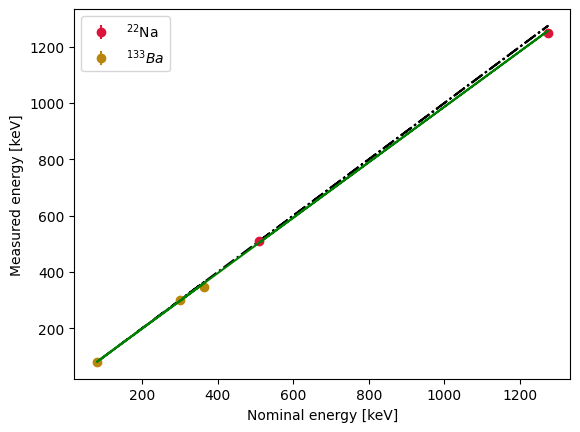

In [88]:
plt.errorbar(en_ch_5[0:2], ch_5[0:2], yerr=sigma_ch_5[0:2], ls='', marker='o', color='crimson', label='$^{22}$Na')

plt.errorbar(en_ch_5[2:], ch_5[2:], yerr=sigma_ch_5[2:], ls='', marker='o', color='darkgoldenrod', label='$^{133}Ba$')
plt.errorbar(en_ch_5, retta(en_ch_5, par5[0], par5[1]), color='green')
plt.plot(en_ch_5, en_ch_5, ls='-.', color='black')
plt.xlabel("Nominal energy [keV]")
plt.ylabel("Measured energy [keV]")
plt.legend()  # Add legend for each subplot

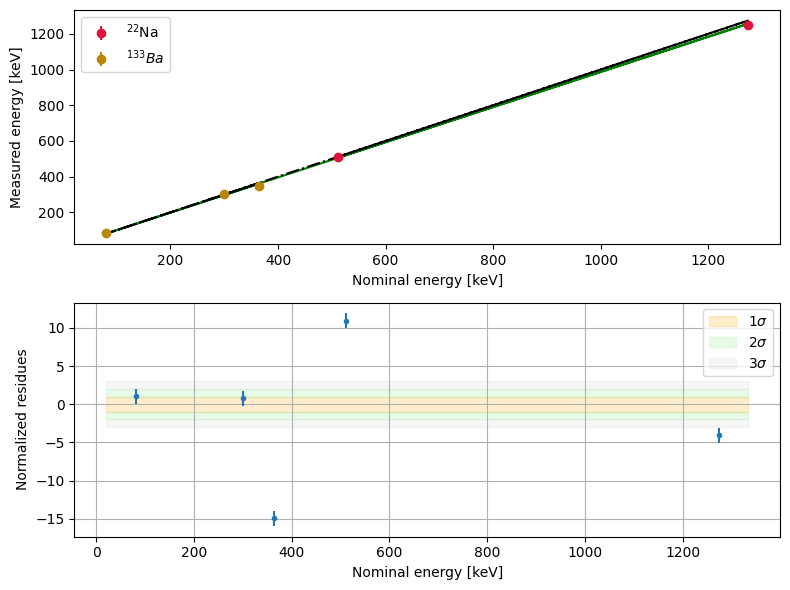

[  6.0312767   -6.27280858   0.63505082 -11.80773264   5.01300297]


In [89]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.errorbar(en_ch_5[0:2], ch_5[0:2], yerr=sigma_ch_5[0:2], ls='', marker='o', color='crimson', label='$^{22}$Na')

ax1.errorbar(en_ch_5[2:], ch_5[2:], yerr=sigma_ch_5[2:], ls='', marker='o', color='darkgoldenrod', label='$^{133}Ba$')
ax1.plot(en_ch_5, retta(en_ch_5,par5[0], par5[1]), color='green')
ax1.plot(en_ch_5, en_ch_5, ls='-.', color='black')
ax1.set_xlabel("Nominal energy [keV]")
ax1.set_ylabel("Measured energy [keV]")
ax1.legend()  # Add legend for each subplot

residue= ch_5- retta(en_ch_5, par5[0], par5[1])
norm_res = residue / sigma_ch_5

ax2.errorbar(en_ch_5, norm_res, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Nominal energy [keV]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(residue)

In [ ]:
#kolmogorov smirnov
print(' ')
print('Test del K-S per il set 2')
t2=[]
valori=residue
N=len(valori)
media=np.mean(valori)
sigma=np.std(valori)
for j in range(0,N):
  t2.append((valori[j] - media)/sigma)
t2=sorted(t2)
print(t2)

In [ ]:
diff=[]
cumulata=[0.167, 0.167*2, 0.167*3, 0.167*4, 0.167*5, 1]
#devi metterci i valori che ottieni facendo 1/N e sommandoli
#in t2 devi mettere i valori di t ottenuti con distcalc
#devi mettere 1-alpha di distcalc
t=[1-0.98228, 1-0.57146, 1-0.39718, 1-0.2967, 1-0.29416, 1-0.17168]
for i in range(0,N):
  diff.append(cumulata[i]-t[i])
print(f'differenza={diff}')
#cerca il valore nella tabella
print(min(diff))
print(max(diff))
#la significatività è superiore al 20%

### ch 6

In [ ]:
ch=6
ch_6=np.abs([peak_e[ch], peak_f[ch]])/coeff_cal[ch]*energia
en_ch_6=[511, 1274, ]
sigma_ch_6=[sigma_e[ch], sigma_f[ch]]/coeff_cal[ch]*energia
par6, cov6= curve_fit(retta, en_ch_6, ch_6, sigma=sigma_ch_6)
print(par6, np.sqrt(cov6[0][0]), np.sqrt(cov6[1][1]))

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.errorbar(en_ch_6, ch_6, yerr=sigma_ch_6, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
ax1.plot(en_ch_6, retta(en_ch_6,par6[0], par6[1]), color='green')
ax1.plot(en_ch_6, en_ch_6, ls='-.', color='black')
ax1.set_xlabel("Nominal energy [keV]")
ax1.set_ylabel("Measured energy [keV]")
ax1.legend()  # Add legend for each subplot

residue= ch_6- retta(en_ch_6, par6[0], par6[1])
norm_res = residue / sigma_ch_5

ax2.errorbar(en_ch_6, norm_res, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Nominal energy [keV]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(residue)

In [ ]:
ch=7
ch_7=[peak_e[ch], peak_f[ch]]/coeff_cal*energia
en_ch_7=[511, 1274, ]/coeff_cal*energia
sigma_ch_7=[sigma_e[ch], sigma_f[ch]]/coeff_cal*energia

In [ ]:
ch=8
ch_8=[peak_e[ch], peak_f[ch]]/coeff_cal*energia
en_ch_8=[511, 1274, ]/coeff_cal*energia
sigma_ch_8=[sigma_e[ch], sigma_f[ch]]/coeff_cal*energia

In [ ]:
ch=9
ch_9=[peak_e[ch], peak_f[ch]]/coeff_cal*energia
en_ch_9=[511, 1274, ]/coeff_cal*energia
sigma_ch_9=[sigma_e[ch], sigma_f[ch]]/coeff_cal*energia

In [ ]:
ch=10
ch_10=[peak_e[ch], peak_f[ch]]/coeff_cal*energia
en_ch_10=[511, 1274, ]/coeff_cal*energia
sigma_ch_10=[sigma_e[ch], sigma_f[ch]]/coeff_cal*energia

In [2]:
ch=11
ch_11=[peak_e[ch], peak_f[ch]]/coeff_cal*energia
en_ch_11=[511, 1274, ]/coeff_cal*energia
sigma_ch_11=[sigma_e[ch], sigma_f[ch]]/coeff_cal*energia

In [ ]:
ch=12
ch_12=[peak_e[ch], peak_f[ch]]/coeff_cal*energia
en_ch_12=[511, 1274, ]/coeff_cal*energia
sigma_ch_12=[sigma_e[ch], sigma_f[ch]]/coeff_cal*energia

In [ ]:
ch=13
ch_13=[peak_e[ch], peak_f[ch]]/coeff_cal*energia
en_ch_13=[511, 1274, ]/coeff_cal*energia
sigma_ch_13=[sigma_e[ch], sigma_f[ch]]/coeff_cal*energia

In [ ]:
ch=14
ch_14=[peak_e[ch], peak_f[ch]]/coeff_cal*energia
en_ch_14=[511, 1274, ]/coeff_cal*energia
sigma_ch_14=[sigma_e[ch], sigma_f[ch]]/coeff_cal*energia

In [ ]:
ch=15
ch_15=[peak_e[ch], peak_f[ch]]/coeff_cal*energia
en_ch_15=[511, 1274, ]/coeff_cal*energia
sigma_ch_15=[sigma_e[ch], sigma_f[ch]]/coeff_cal*energia